In [12]:
import time
import base64
import datetime
import requests
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from cryptography.hazmat.primitives import serialization, hashes
from cryptography.hazmat.primitives.asymmetric import padding
from google.colab import userdata


In [13]:
def kalshi_headers(method: str, path: str) -> dict:
    api_key = userdata.get("KALSHI_API_KEY")
    private_key_pem = userdata.get("KALSHI_PRIVATE_KEY")

    timestamp = str(int(time.time() * 1000))
    message = f"{timestamp}{method}{path}"

    private_key = serialization.load_pem_private_key(
        private_key_pem.encode(), password=None
    )

    signature = base64.b64encode(
        private_key.sign(
            message.encode(),
            padding.PSS(
                mgf=padding.MGF1(hashes.SHA256()),
                salt_length=padding.PSS.DIGEST_LENGTH,
            ),
            hashes.SHA256(),
        )
    ).decode()

    return {
        "KALSHI-ACCESS-KEY": api_key,
        "KALSHI-ACCESS-SIGNATURE": signature,
        "KALSHI-ACCESS-TIMESTAMP": timestamp,
    }


In [14]:
def fetch_belief_trace(
    series_ticker: str,
    market_ticker: str,
    start_ts: int,
    end_ts: int,
    interval_minutes: int = 60,
) -> pd.DataFrame:
    """
    Fetch historical belief trace for a Kalshi market.
    interval_minutes must be one of: 1, 5, 15, 60, 1440
    """

    path = (
        f"/trade-api/v2/series/{series_ticker}"
        f"/markets/{market_ticker}/candlesticks"
    )

    url = (
        f"https://api.elections.kalshi.com{path}"
        f"?start_ts={start_ts}"
        f"&end_ts={end_ts}"
        f"&period_interval={interval_minutes}"
    )

    headers = kalshi_headers("GET", path)
    resp = requests.get(url, headers=headers)

    if resp.status_code != 200:
        raise RuntimeError(resp.text)

    candles = resp.json().get("candlesticks", [])

    if not candles:
        raise ValueError(
            f"No candlesticks returned for {market_ticker} "
            f"in window {start_ts} → {end_ts}"
        )

    df = pd.DataFrame([{
        "time": datetime.datetime.fromtimestamp(c["end_period_ts"]),
        "price": c["price"]["close_dollars"] if c["price"]["close"] else None,
        "volume": c["volume"],
        "open_interest": c["open_interest"],
    } for c in candles])

    return df.sort_values("time").reset_index(drop=True)


In [15]:
def save_belief_trace(df: pd.DataFrame, name: str):
    path = Path(f"/content/{name}.csv")
    df.to_csv(path, index=False)
    print(f"Saved belief trace → {path}")


In [16]:
def list_all_markets(series_ticker: str):
    url = "https://api.elections.kalshi.com/trade-api/v2/markets"
    params = {
        "series_ticker": series_ticker
    }

    resp = requests.get(url, params=params)
    if resp.status_code != 200:
        raise RuntimeError(resp.text)

    return resp.json().get("markets", [])


In [17]:
markets = list_all_markets("KXHOUSEEPSTEIN")

for m in markets:
    print(
        f"{m['ticker']} | {m['title']} | "
        f"Status: {m['status']} | "
        f"Resolved: {m.get('close_time')}"
    )


KXHOUSEEPSTEIN-26JAN01V | Will the bill to unseal Epstein records receive a veto-proof majority in the House? | Status: finalized | Resolved: 2025-11-18T21:43:40.03039Z
KXHOUSEEPSTEIN-26JAN01-350 | Will more than 350 House vote Yea on a bill that mandates any part of the federal government release files related to Jeffrey Epstein? | Status: finalized | Resolved: 2025-11-18T20:00:38.902928Z
KXHOUSEEPSTEIN-26JAN01-345 | Will between 340 and 350 House vote Yea on a bill that mandates any part of the federal government release files related to Jeffrey Epstein? | Status: finalized | Resolved: 2025-11-18T20:00:38.902928Z
KXHOUSEEPSTEIN-26JAN01-334 | Will between 330 and 339 House vote Yea on a bill that mandates any part of the federal government release files related to Jeffrey Epstein? | Status: finalized | Resolved: 2025-11-18T20:00:38.902928Z
KXHOUSEEPSTEIN-26JAN01-324 | Will between 320 and 329 House vote Yea on a bill that mandates any part of the federal government release files relat

In [18]:
# Resolution time
end_ts = int(datetime.datetime(2025, 11, 18).timestamp())

# Look 60 days before resolution
start_ts = end_ts - 60 * 24 * 60 * 60

df = fetch_belief_trace(
    series_ticker="KXHOUSEEPSTEIN",
    market_ticker="KXHOUSEEPSTEIN-26JAN01V",
    start_ts=start_ts,
    end_ts=end_ts,
    interval_minutes=60   # 1 hour
)

save_belief_trace(
    df,
    "belief_trace__kalshi__house"
)


Saved belief trace → /content/belief_trace__kalshi__house.csv


In [26]:
# Load belief trace
df = pd.read_csv(
    "/content/belief_trace__kalshi__house.csv",
    parse_dates=["time"]
)

df = df.sort_values("time").reset_index(drop=True)
df.head()


,time,price,volume,open_interest
0,2025-11-15 22:00:00,NaN,0,0
1,2025-11-15 23:00:00,0.41,250,250
2,2025-11-16 01:00:00,NaN,0,250
3,2025-11-16 03:00:00,NaN,0,250
4,2025-11-16 04:00:00,NaN,0,250


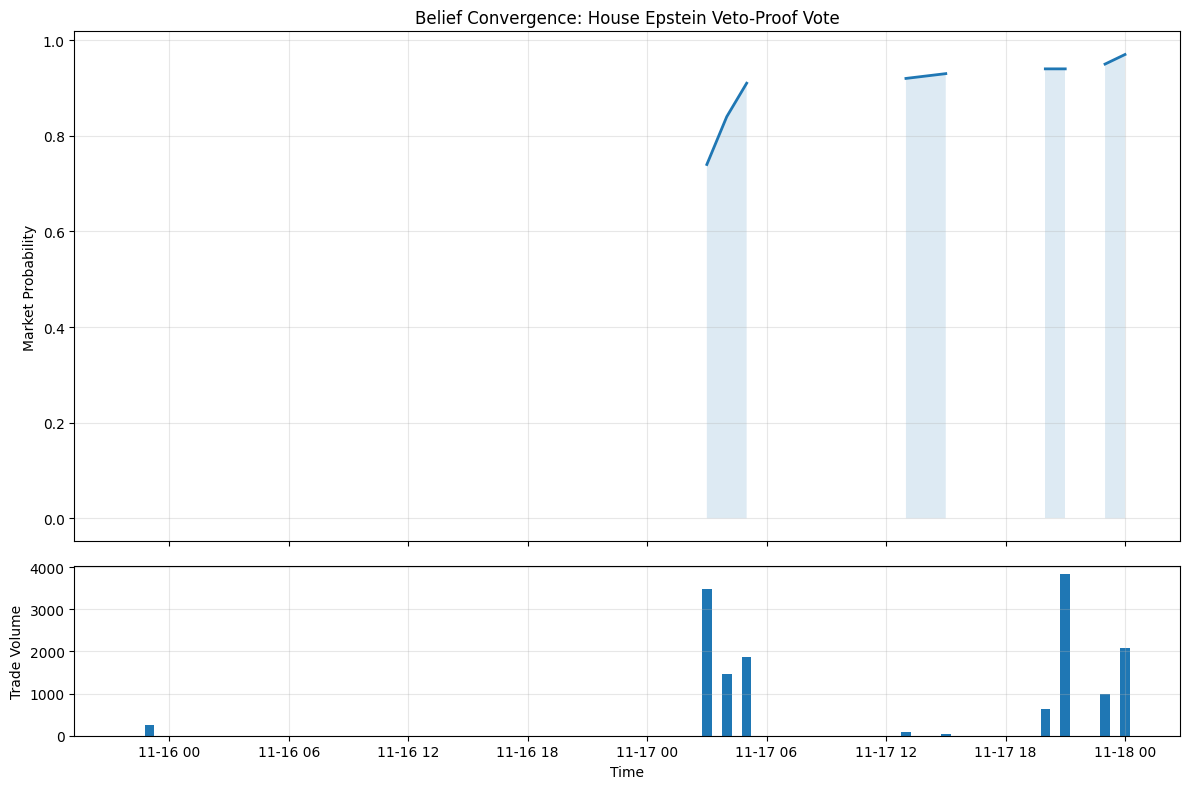

In [20]:

fig, (ax1, ax2) = plt.subplots(
    2, 1,
    figsize=(12, 8),
    sharex=True,
    gridspec_kw={"height_ratios": [3, 1]}
)

# --- Belief (probability) ---
ax1.plot(
    df["time"],
    df["price"],
    linewidth=2
)
ax1.fill_between(
    df["time"],
    df["price"],
    alpha=0.15
)
ax1.set_ylabel("Market Probability")
ax1.set_title("Belief Convergence: House Epstein Veto-Proof Vote")
ax1.grid(alpha=0.3)

# --- Activity (volume) ---
ax2.bar(
    df["time"],
    df["volume"],
    width=0.02
)
ax2.set_ylabel("Trade Volume")
ax2.set_xlabel("Time")
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [22]:
df["belief_change"] = df["price"].diff().abs()

belief_volatility = df["belief_change"].mean()
belief_max_jump = df["belief_change"].max()

belief_volatility, belief_max_jump


(np.float64(0.040000000000000015), 0.09999999999999998)

In [23]:
inactive_fraction = (df["volume"] == 0).mean()
inactive_fraction


np.float64(0.7619047619047619)

In [24]:
collapse_threshold = 0.95

collapsed = df[df["price"] >= collapse_threshold]

if not collapsed.empty:
    collapse_time = collapsed.iloc[0]["time"]
else:
    collapse_time = None

collapse_time


Timestamp('2025-11-17 23:00:00')

In [25]:
summary = {
    "num_observations": len(df),
    "belief_volatility_mean": belief_volatility,
    "belief_max_jump": belief_max_jump,
    "inactive_fraction": inactive_fraction,
    "collapse_time": collapse_time,
}

pd.Series(summary)


,0
num_observations,42
belief_volatility_mean,0.04
belief_max_jump,0.1
inactive_fraction,0.761905
collapse_time,2025-11-17 23:00:00


In [28]:
from google.colab import files

files.download("/content/belief_trace__kalshi__house.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>